# REAL ESTATE PRICE PREDICTION

In [682]:
# Загружаем необходимые библиотеки:

import numpy as np
import pandas as pd
import pickle 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [683]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [684]:
TRAIN_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH ='/Users/admin/Desktop/GeekBrains/Библиотеки_Python/real-estate-price-prediction-moscow/test.csv'
PREPARED_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/real-estate-price-prediction-moscow/Prepared_file.csv'
TEST_PREPARED_DATASET_PATH = '/Users/admin/Desktop/GeekBrains/Библиотеки_Python/real-estate-price-prediction-moscow/Test_prepared_file.csv'

In [685]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Первичный анализ данных 

In [686]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(10)


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [687]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [688]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [689]:
train_df.shape[1] - 1 == test_df.shape[1]

True

Оптимизируем объем памяти:

In [690]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [691]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


В результате анализа данных таблицы сделала следующие выводы: 
- предположительно есть выбросы в признаке Rooms (макс. число комнат 19, очень расходится с большинством данных), Floor и HouseFloor (макс.этаж 42 и 117)
- очевидные выбросы в LifeSquare и в KitchenSquare: макс. значение 7480.592 и 2014.00 намного выше максимальной общей площади(Square). Также HouseYear имеет неадекватное максимальное значение.

In [692]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Видим пропущенные данные в полях LifeSquare, Healthcare_1. Нужно будет заполнить пропуски. 

In [693]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

Определим строковые значения для признаков Id и DistrictId, так как очевидно, что их значение не является непрерывной величиной, скорее всего это категория.

In [694]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

### Распределение целевой переменной

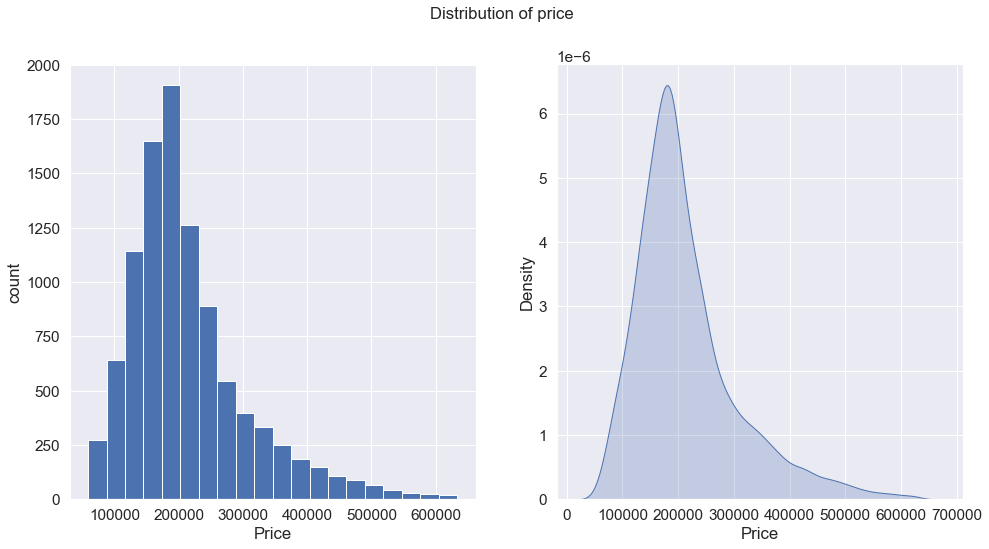

In [695]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

In [696]:
train_df['Price'].sort_values()

1319     59174.777344
1709     59877.593750
130      60502.582031
8191     60825.031250
8563     60828.261719
            ...      
8983    624680.125000
9826    625678.625000
7173    625820.062500
2041    627525.062500
8803    633233.437500
Name: Price, Length: 10000, dtype: float32

In [697]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()

In [698]:
target_mean

214138.94

In [699]:
target_median

192269.65625

## Анализ признаков и обработка выбросов.

Найдем числовые признаки:

In [700]:
df_num_features = train_df.select_dtypes(include=['float32', 'float16','int8', 'int32','int16'])
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250


Удалим столбец с целевой переменной и посмотрим распределение каждого признака на гистограмме:

In [701]:
df_num_features.drop(['Price'], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

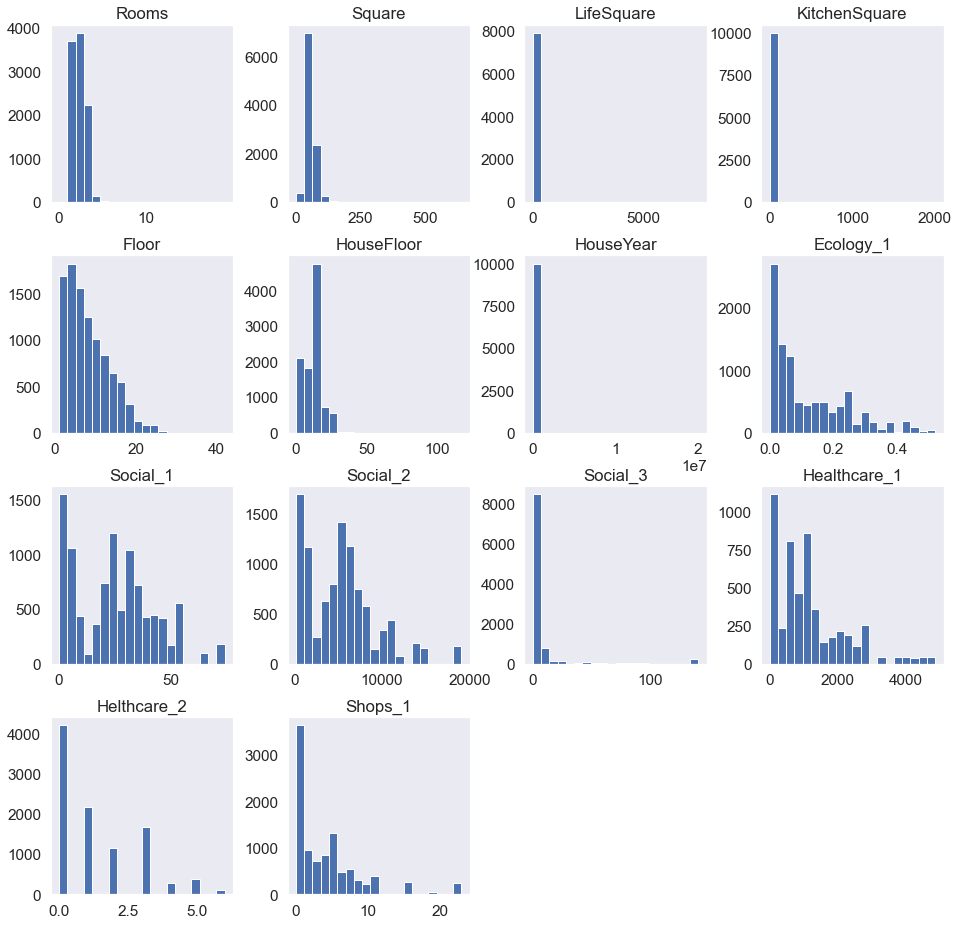

In [702]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

Анализируя данные гистограммы можно сделать вывод, что в данных Rooms, Square, LifeSquare, KitchenSquare, HouseFloor присутствуют явные выбросы. Заменим их на значение медианы для каждого признака.

#### Проверим количество значений Rooms, чтобы решить, какие из них точно стоит обработать:

In [703]:
train_df['Rooms'].value_counts().sort_index(ascending=True)

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Скорее всего выбросы - это значения 0, 10 и 19. 6-комнатные квартиры, предположу, что редко, но бывают. Заменим выбросы на медиану, а количество комнат, равное нулю, примем за 1. Также создадим дополнительный бинарный признак 'Rooms_outlier', чтобы пометить объекты с неадекватным количеством комнат:

In [704]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [705]:
train_df.loc[train_df['Rooms'] == 1, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

#### Обработаем признак Square.
На гистограмме видим, что выбросные значения идут примерно до 20 и после значения 150. Все, что меньше 20 или больше 150, заменим на медиану.

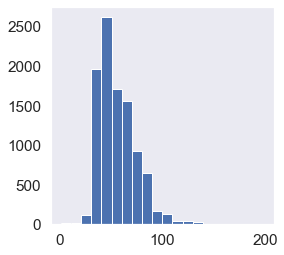

In [706]:
train_df[train_df['Square'] < 200]['Square'].hist(figsize=(4, 4), bins=20, grid=False);

In [707]:
train_df.loc[((train_df['Square'] < 20) | (train_df['Square'] > 150)), 'Square'] = train_df['Square'].median()

In [708]:
train_df['Square'].median()

52.513309478759766

#### Обработаем признак LifeSquare.

In [709]:
train_df['LifeSquare'].isna().sum()

2113

Видим 2113 пропущенных значений LifeSquare.

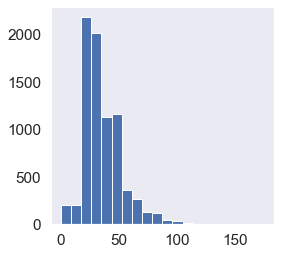

In [710]:
train_df[train_df['LifeSquare'] < 200]['LifeSquare'].hist(figsize=(4, 4), bins=20, grid=False);

На гистограмме четко видно, что значения LifeSquare больше 150 больше похожи на выбросы, а также малое количество значения до 15-20. 
Попробуем заменить все значения, выше 150, на медиану.

In [711]:
train_df.loc[(train_df['LifeSquare'] > 150), 'LifeSquare'] = train_df['LifeSquare'].median()

In [712]:
train_df['LifeSquare'].median()

32.7812614440918

#### Обработка признака KitchenSquare.

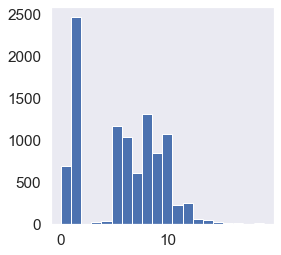

In [713]:
train_df[train_df['KitchenSquare'] < 20]['KitchenSquare'].hist(figsize=(4, 4), bins=20, grid=False);

По гистограмме можем сделать вывод, что кухня больше 20м встречается очень редко.

In [714]:
(train_df['KitchenSquare'] > 20).value_counts()

False    9952
True       48
Name: KitchenSquare, dtype: int64

Посчитаем квантили:

In [715]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Создадим условие для проверки площади кухни: если оно пропущено или его значение выше квантиля 0.975, то заменяем на медиану. Если <3, то приравняем к 3. 

In [716]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

#### Обработка признаков Floor и HouseFloor.

In [717]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

На первый взгляд с признаком Floor все хорошо.

In [718]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

Вызывают подозрение значения 0, 99 и 117, так как они явно выбиваются из общей картины, и 0 этажность быть не может. Также проверим, сколько значений Floor превышают значение этажности дома HouseFloor.

In [719]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Достаточно много, пометим их через новый признак:

In [720]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Этаж, равный нулю, приравняем к медиане:

In [721]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

Несоответствие этажа и этажности дома заменим на рандомное число от 1 до максимального этажа конкретного дома:

In [722]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [723]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

#### Обработка признака HouseYear.

In [725]:
train_df['HouseYear'].sort_values()

6794        1910
2795        1912
2066        1912
6250        1914
7610        1916
          ...   
8296        2020
2350        2020
7246        2020
8828        4968
9163    20052011
Name: HouseYear, Length: 10000, dtype: int32

Видим, что всего два значения (4968 и 20052011) явно выбросы, заменим их на текущий год и отметим через бинарный признак:

In [726]:
current_year = datetime.now().year
train_df['HouseYear_outlier'] = 0
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1

In [727]:
train_df.loc[train_df['HouseYear'] > current_year, 'HouseYear'] = current_year

## Обработка пропусков.

In [729]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
HouseYear_outlier        0
dtype: int64

<!-- Создадим вспомогательные признаки и заполним их 0, если пропуска в LifeSquare и Healthcare_1 нет и 1, когда пропуски есть. Таким образом мы пометим отсутствующие признаки, которые в последующем будем заполнять: -->

Теперь обработаем пропущенные значения в признаке LifeSquare. Создадим вспомогательные признак и заполним его 0, если пропуска в LifeSquare нет и 1, когда пропуски есть. Таким образом мы пометим отсутствующий признак, который в последующем будем заполнять.

Заменять на среднее было бы не совсем корректно, так как оно должно соответствовать общему метражу и площади кухни, поэтому предположим, что LifeSquare - это разница между общей площадью Square, площадью кухни KitchenSquare и площадью подсобных помещений и санузлов (допустим, что это 3 кв.м):

In [730]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,3.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,3.0
9,79.867477,75.085129,3.0


In [731]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

#### Healthcare_1

In [732]:
train_df['Healthcare_1_nan'] = train_df['Healthcare_1'].isna() * 1

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mode()[0]
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,540.0,0,0,B,305018.875000,0,0,0,1,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.546875,0,0,0,0,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.718750,0,0,0,0,0
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,540.0,0,1,B,168106.000000,0,0,0,1,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,540.0,0,6,B,343995.093750,0,0,0,0,1


Не совсем ясно, что обозначает данный признак и в чем он выражается, предполагаю, что это не числовое значение переменной, а возможно, какая-то категория. Создадим вспомогательный признак и заполним его 0, если пропуска в Healthcare_1 нет и 1, когда пропуск есть. Попробуем заменить пропуски на на моду.

In [733]:
train_df['Healthcare_1'].describe()

count    10000.000000
mean       853.630920
std        795.918945
min          0.000000
25%        540.000000
50%        540.000000
75%        990.000000
max       4849.000000
Name: Healthcare_1, dtype: float64

In [734]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Id                  10000 non-null  object  
 1   DistrictId          10000 non-null  object  
 2   Rooms               10000 non-null  float32 
 3   Square              10000 non-null  float32 
 4   LifeSquare          10000 non-null  float32 
 5   KitchenSquare       10000 non-null  float32 
 6   Floor               10000 non-null  int64   
 7   HouseFloor          10000 non-null  float32 
 8   HouseYear           10000 non-null  int32   
 9   Ecology_1           10000 non-null  float32 
 10  Ecology_2           10000 non-null  category
 11  Ecology_3           10000 non-null  category
 12  Social_1            10000 non-null  int8    
 13  Social_2            10000 non-null  int16   
 14  Social_3            10000 non-null  int16   
 15  Healthcare_1        10000 non-null  f

Пропущенных значений больше нет.

## Создание класса для подготовки исходных данных.

In [760]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[((X['Square'] < 20) | (X['Square'] > 150)), 'Square'] = self.medians['Square']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
         # Healthcare_1
        
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        health_moda = X['Healthcare_1'].mode()[0]
        X['Healthcare_1'].fillna(health_moda, inplace=True)
        
            
        # LifeSquare
        X.loc[(X['LifeSquare'] > 150), 'LifeSquare'] = self.medians['LifeSquare']
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Построение новых признаков

#### Dummies

- Мы видим только два значения (А и В) у данных категориальных переменных, поэтому заменим их на бинарный признак (А = 1, В = 0):

In [736]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### DistrictSize, IsDistrictLarge

- Рассмотрим признак DistrictId, можно предположить, что частота его встречаемости как-то влияет на популярность района и его размер. Создадим датафрейм, подсчитывающий частоту встречаемости каждого района, а затем добавим его как новый признак:

In [737]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [738]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,0,1,1,851
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,0,78
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,0,652
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,0,1,1,652
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,1,89


In [739]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [740]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [741]:
train_df['DistrictId'].value_counts().sort_index()

0       48
1      652
10      56
100     25
101     97
      ... 
95      15
96      71
97      10
98      21
99      97
Name: DistrictId, Length: 205, dtype: int64

#### MedPriceByDistrict и PricePerMeter

- Сформируем два новых признака: средней цены по району и за метр квадратный в зависимости от района:

In [742]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [743]:
med_price_by_district.shape

(672, 3)

In [744]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,305018.875000,0,0,0,1,1,851,1,213530.781250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,177734.546875,0,0,0,0,0,78,0,146032.828125
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,1,282078.718750,0,0,0,0,0,652,1,244005.281250
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,168106.000000,0,0,0,1,1,652,1,146735.671875
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,343995.093750,0,0,0,0,1,89,0,201584.437500


In [745]:
train_df['PricePerMeter'] = train_df['MedPriceByDistrict'] / train_df['Square']
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,PricePerMeter
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,305018.875000,0,0,0,1,1,851,1,213530.781250,1856.348511
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,177734.546875,0,0,0,0,0,78,0,146032.828125,3666.170654
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,282078.718750,0,0,0,0,0,652,1,244005.281250,3114.607910
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,168106.000000,0,0,0,1,1,652,1,146735.671875,3631.180420
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,343995.093750,0,0,0,0,1,89,0,201584.437500,3135.789551


#### MedPriceByFloorYear

Создадим новые категории в зависимости средней стоимости квартир от этажа и года постройки дома и новый признак:

In [746]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

In [747]:
train_df['HouseYear'].describe()

count    10000.000000
mean      1984.872600
std         18.416734
min       1910.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2021.000000
Name: HouseYear, dtype: float64

- Посмотрим на год постройки дома и в зависимости от этого разделим все дома на 6 категорий: 
    - до 1941, 
    - 1941-1960,
    - 1960-1980,
    - 1980-2000,
    - 2000-2010,
    - старше 2010 года:

In [748]:
def year_to_cat_pandas(X):
    bins = [0, 1941, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [749]:
train_df = year_to_cat_pandas(train_df)
train_df = floor_to_cat_pandas(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,PricePerMeter,year_cat,floor_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,1,851,1,213530.781250,1856.348511,5,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.828125,3666.170654,2,2
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.281250,3114.607910,3,0
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,0,1,1,652,1,146735.671875,3631.180420,2,3
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,1,89,0,201584.437500,3135.789551,2,4


In [750]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,377289.562500
1,0,1,322905.062500
2,0,2,386374.062500
3,0,3,274992.468750
4,1,0,253225.890625


In [751]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,PricePerMeter,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,1,1,851,1,213530.781250,1856.348511,5,1,165636.156250
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.828125,3666.170654,2,2,190883.500000
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.281250,3114.607910,3,0,204940.078125
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,0,1,1,652,1,146735.671875,3631.180420,2,3,183494.406250
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,1,89,0,201584.437500,3135.789551,2,4,173934.859375


- Также создадим еще один новый бинарный признак в зависимости от года постройки дома:
    - 1 - новый дом (<= 5 лет)
    - 0 - старый дом (> 5 лет)

In [752]:
def age_to_binary_cat(X):
    X['age_to_binary_cat'] = 0
    X.loc[X['HouseYear'] >= 2015, 'age_to_binary_cat'] = 1  

    return X

In [753]:
train_df = age_to_binary_cat(train_df)
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,LifeSquare_nan,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,PricePerMeter,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,1,851,1,213530.781250,1856.348511,5,1,165636.156250,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,78,0,146032.828125,3666.170654,2,2,190883.500000,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,652,1,244005.281250,3114.607910,3,0,204940.078125,0


#### MedHealthByDistrict

In [814]:
med_health_by_distr = train_df.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2':'median'}).rename(columns={'Helthcare_2': 'MedHealthByDistrict'})
med_health_by_distr

,DistrictId,MedHealthByDistrict
0,0,5.0
1,1,0.0
2,2,0.0
3,3,2.0
4,4,1.0
...,...,...
200,202,5.0
201,205,2.0
202,207,2.0
203,208,1.0


In [754]:
train_df = train_df.merge(med_health_by_distr, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,PricePerMeter,year_cat,floor_cat,MedPriceByFloorYear,age_to_binary_cat,MedHealthByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,1,851,1,213530.781250,1856.348511,5,1,165636.156250,0,0.0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,78,0,146032.828125,3666.170654,2,2,190883.500000,0,1.0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,652,1,244005.281250,3114.607910,3,0,204940.078125,0,0.0
3,2352,1,1.0,40.409908,34.409908,3.0,10,22.0,1977,0.007122,...,1,652,1,146735.671875,3631.180420,2,3,183494.406250,0,0.0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,1,89,0,201584.437500,3135.789551,2,4,173934.859375,0,0.0


#### Социальные показатели в зависимости от размера района.

Создадим еще новые признаки в зависимости от размера каждого района:

In [544]:
train_df['Social_1_DS'] = train_df['Social_1'] / train_df['DistrictSize']
train_df['Social_2_DS'] = train_df['Social_2'] / train_df['DistrictSize']
train_df['Shops_1_DS'] = train_df['Shops_1'] / train_df['DistrictSize']
train_df['Healthcare_1_DS'] = train_df['Healthcare_1'] / train_df['DistrictSize']
train_df['Helthcare_2_DS'] = train_df['Helthcare_2'] / train_df['DistrictSize']

In [787]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_health_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.age_to_binary_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            self.med_health_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2':'median'}).\
                                            rename(columns={'Helthcare_2': 'MedHealthByDistrict'})
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
            
         # Социальные показатели на размер района
        #def socials_ds(self, X): 
        X['Social_1_DS'] = X['Social_1'] / X['DistrictSize']
        X['Social_2_DS'] = X['Social_2'] / X['DistrictSize']
        X['Shops_1_DS'] = X['Shops_1'] / X['DistrictSize']
        X['Healthcare_1_DS'] = X['Healthcare_1'] / X['DistrictSize']
        X['Helthcare_2_DS'] = X['Helthcare_2'] / X['DistrictSize']
        
        # обрабатываем возможные ошибки
        X['Social_1_DS'].replace([np.inf, -np.inf], 0, inplace=True)
        X['Social_2_DS'].replace([np.inf, -np.inf], 0, inplace=True)
        X['Shops_1_DS'].replace([np.inf, -np.inf], 0, inplace=True)
        X['Healthcare_1_DS'].replace([np.inf, -np.inf], 0, inplace=True)                                                 
        X['Helthcare_2_DS'].replace([np.inf, -np.inf], 0, inplace=True)        
                 
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.age_to_binary_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_health_by_district is not None:
            X = X.merge(self.med_health_by_district, on='DistrictId', how='left')
            self.med_health_by_district_median = self.med_health_by_district['MedHealthByDistrict'].median()
            X['MedHealthByDistrict'].fillna(self.med_health_by_district_median, inplace=True)
        
        X['PricePerMeter'] = X['MedPriceByDistrict'] / X['Square']
                
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    def age_to_binary_cat(self, X):
        X['age_to_binary_cat'] = 0
        X.loc[X['HouseYear'] >= 2015, 'age_to_binary_cat'] = 1  
        return X    

In [546]:
train_df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
test_df.to_csv(TEST_PREPARED_DATASET_PATH, index=False, encoding='utf-8')


## Отбор признаков

In [547]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'PricePerMeter',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear',
 'age_to_binary_cat',
 'MedHealthByDistrict',
 'Social_1_DS',
 'Social_2_DS',
 'Shops_1_DS',
 'Healthcare_1_DS',
 'Helthcare_2_DS']

In [634]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2','Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'Healthcare_1_nan', 'DistrictSize',
                  'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedHealthByDistrict', 'PricePerMeter', 'age_to_binary_cat', 'Social_1_DS', 'Social_2_DS', 'Shops_1_DS', 'Healthcare_1_DS', 'Helthcare_2_DS']

target_name = 'Price'

## Разбиение на train и test 

In [781]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)


X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [782]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [783]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [788]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 39), (3300, 39), (5000, 39))

In [789]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [790]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [791]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,PricePerMeter,age_to_binary_cat,Social_1_DS,Social_2_DS,Shops_1_DS,Healthcare_1_DS,Helthcare_2_DS
0,1.0,43.380798,37.380798,3.0,18,25.0,1977,0.075779,1,1,...,104300.893609,174339.691014,0.0,2404.310189,0,0.016129,3.862903,0.005376,1.451613,0.000000
1,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,1,1,...,197241.123890,179756.510675,3.0,2359.446184,0,0.148649,43.229730,0.155405,7.067568,0.020270
2,2.0,53.610583,31.289235,8.0,6,12.0,1979,0.298205,1,1,...,228796.542555,192048.442631,1.0,4267.749551,0,0.250000,63.250000,0.046875,8.437500,0.015625
3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,1,1,...,184712.770172,179756.510675,2.0,3560.551303,0,0.840909,120.181818,0.045455,44.022727,0.068182
4,1.0,53.810968,47.810968,3.0,4,13.0,1977,0.072158,1,1,...,131107.271962,189132.246105,0.0,2436.441439,0,0.012195,3.835366,0.000000,3.292683,0.000000


In [627]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,PricePerMeter,age_to_binary_cat,Social_1_DS,Social_2_DS,Shops_1_DS,Healthcare_1_DS,Helthcare_2_DS
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,171145.169069,189216.333663,1036.0,4644.672365,0,0.315789,57.605263,0.013158,13.631579,0.013158
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,131107.271962,177755.781775,540.0,3085.319298,1,0.012195,3.835366,0.000000,3.292683,0.000000
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,165993.292450,174137.278013,540.0,2791.507307,0,0.015517,3.262069,0.001724,0.931034,0.000000
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,172778.615365,179672.834653,540.0,3480.210119,0,0.005376,1.276882,0.000000,1.451613,0.000000
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,164116.183543,192086.822606,540.0,3048.387063,0,0.538462,118.692308,0.092308,15.230769,0.000000


## Стандартизация модели

In [576]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 0 to 6699
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                6700 non-null   float64
 1   Square               6700 non-null   float64
 2   LifeSquare           6700 non-null   float64
 3   KitchenSquare        6700 non-null   float64
 4   Floor                6700 non-null   int64  
 5   HouseFloor           6700 non-null   float64
 6   HouseYear            6700 non-null   int64  
 7   Ecology_1            6700 non-null   float64
 8   Ecology_2            6700 non-null   int64  
 9   Ecology_3            6700 non-null   int64  
 10  Social_1             6700 non-null   int64  
 11  Social_2             6700 non-null   int64  
 12  Social_3             6700 non-null   int64  
 13  Healthcare_1         6700 non-null   float64
 14  Helthcare_2          6700 non-null   int64  
 15  Shops_1              6700 non-null   i

In [792]:
feature_names_for_stand = ['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_1','Social_2','Social_3', 'Healthcare_1', 'Helthcare_2','Shops_1','DistrictSize','IsDistrictLarge', 'MedPriceByDistrict','MedPriceByFloorYear', 'MedHealthByDistrict', 'PricePerMeter','Social_1_DS', 'Social_2_DS', 'Shops_1_DS', 'Healthcare_1_DS', 'Helthcare_2_DS']


In [793]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_valid = scaler.transform(X_valid[feature_names_for_stand])
stand_features_test = scaler.transform(test_df[feature_names_for_stand])

In [794]:
X_train[feature_names_for_stand] = stand_features_train
X_valid[feature_names_for_stand] = stand_features_valid
test_df[feature_names_for_stand] = stand_features_test

# Построение моделей

Были построены и протестированы следующие модели: LinearRegression, KNN, Random forest, Gradient Boosting Regressor, Stacking Regressor, VotingRegressor, BaggingRegressor. 
Лучшие результаты были на Gradient Boosting Regressor и Random Forest Regressor с подбором параметров по GridSearchCV.

## Random Forest Regressor

Train R2:	0.807
Test R2:	0.701


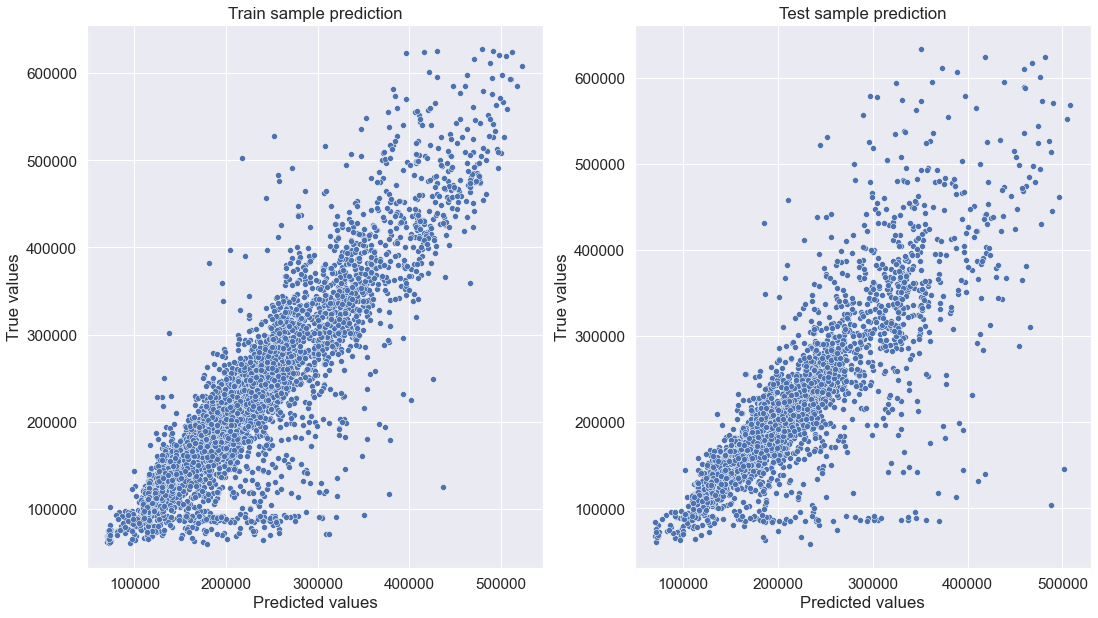

In [828]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=9, # глубина дерева  
                                 min_samples_leaf=10, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 max_features=8,
                                 n_estimators=150  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Хороший результат у модели: на трейне 0.807, тест - 0.701

In [799]:
# rf1_model = RandomForestRegressor(criterion='mse', random_state=42)


In [801]:
# %%time
# params = {
#     'n_estimators': [150, 200, 250],
#     'max_features': np.arange(3, 9),
#     'max_depth': np.arange(5, 10),
#     'min_samples_leaf': [10, 20, 30, 50]
# }

# clf = GridSearchCV(
#     rf1_model,
#     param_grid=params,
#     scoring='r2',
#     cv=KFold(n_splits=5,
#             random_state=21, 
#             shuffle=True),
#     n_jobs= -1
# )
# clf.fit(X_train, y_train)

CPU times: user 6.65 s, sys: 810 ms, total: 7.46 s
Wall time: 6min 33s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'max_features': array([3, 4, 5, 6, 7, 8]),
                         'min_samples_leaf': [10, 20, 30, 50],
                         'n_estimators': [150, 200, 250]},
             scoring='r2')

In [804]:
res = pd.DataFrame(clf.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.691169,0.009231,0.033553,0.001123,5,3,10,150,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.658898,0.620222,0.616745,0.634983,0.634373,0.633044,0.014860,349
1,0.889471,0.018434,0.042819,0.000825,5,3,10,200,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.658793,0.618660,0.616443,0.635730,0.633740,0.632673,0.015182,350


In [805]:
clf.best_params_

{'max_depth': 9,
 'max_features': 8,
 'min_samples_leaf': 10,
 'n_estimators': 150}

In [806]:
clf.best_score_

0.745386509268273

### Кросс-валидация

In [807]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76130731, 0.70679079, 0.75150458])

In [808]:
cv_score.mean()

0.7398675580808577

### Важность признаков

In [809]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
23,MedPriceByDistrict,0.311770
1,Square,0.208464
0,Rooms,0.098518
2,LifeSquare,0.053836
29,Social_2_DS,0.048981
28,Social_1_DS,0.046589
26,PricePerMeter,0.033217
21,DistrictSize,0.032864
11,Social_2,0.020668
6,HouseYear,0.015483


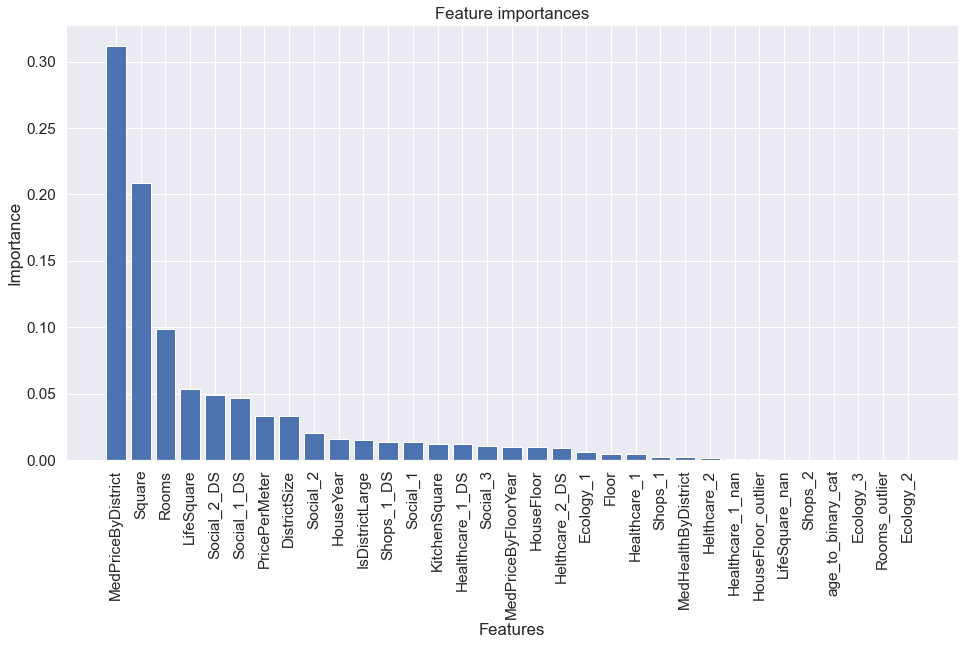

In [815]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.show()

Можно попробовать переобучить модели, убрав бесполезные признаки.

## Gradient Boosting Regressor

In [812]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     random_state=65)

In [813]:
# %%time
# params = {'n_estimators':[50, 100, 200, 400], 
#           'max_depth':[3, 5, 7, 10],
#          'min_samples_leaf': [10, 20, 30, 50]}
# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

CPU times: user 7.24 s, sys: 251 ms, total: 7.49 s
Wall time: 6min 14s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse',
                                                 random_state=65),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [10, 20, 30, 50],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [816]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 400}

In [817]:
final_gb_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=3,
                                        min_samples_leaf=50,
                                        random_state=42,
                                        n_estimators=400)

final_gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', min_samples_leaf=50,
                          n_estimators=400, random_state=42)

Train R2:	0.844
Test R2:	0.716


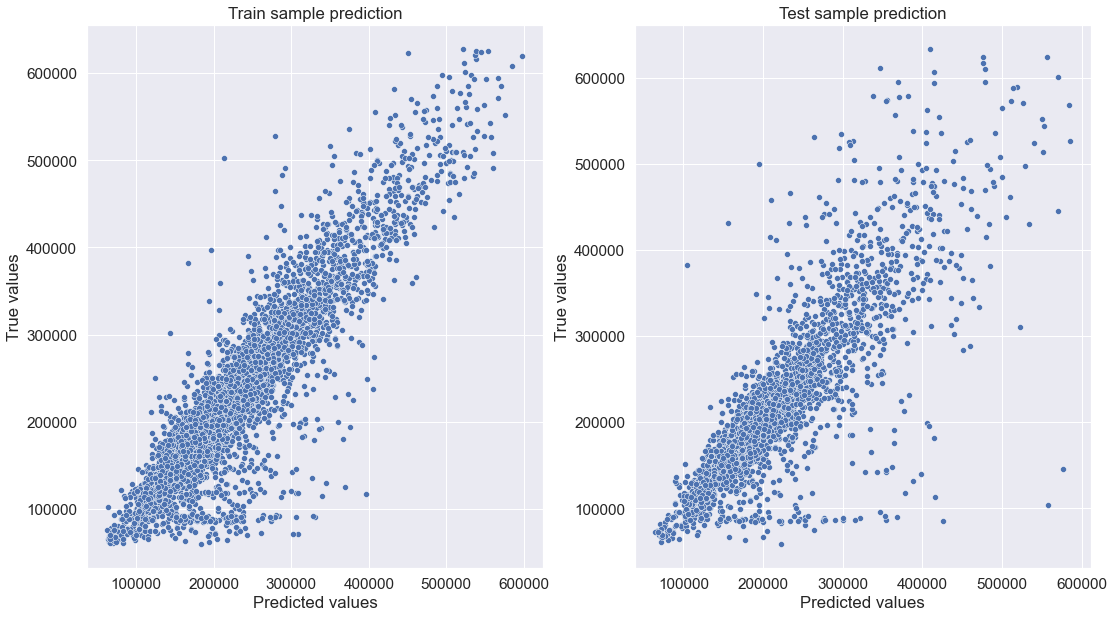

In [818]:
y_train_preds = final_gb_model.predict(X_train)
y_test_preds = final_gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Заметно небольшое переобучение модели, но тем не менее, высокие показатели и на трейне и на тесте. Трейн - 0.844, тест - 0,716

## Прогнозирование на тестовом датасете

In [611]:
test_df.shape

(5000, 33)

In [612]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,MedPriceByDistrict,MedPriceByFloorYear,MedHealthByDistrict,PricePerMeter,age_to_binary_cat,Social_1_DS,Social_2_DS,Shops_1_DS,Healthcare_1_DS,Helthcare_2_DS
0,-1.100828,-1.070281,-1.091595,-0.438141,-0.472602,-0.623367,-0.810087,-0.700705,1,1,...,-0.525859,-0.288394,0.301025,0.595046,0,-0.317158,-0.333492,-0.258270,-0.175193,-0.260053
1,-1.100828,-0.752006,0.166219,1.386312,-0.078938,0.641587,1.758678,-0.399428,1,1,...,-1.037936,-0.695943,-0.387568,-0.704716,1,-0.490540,-0.478654,-0.278894,-0.248358,-0.330144
2,0.133987,0.204565,0.428539,1.021422,2.283044,0.957825,-0.427505,0.764732,1,1,...,-0.591750,-0.862408,-0.387568,-0.949616,0,-0.488643,-0.480202,-0.276191,-0.265071,-0.330144
3,1.368801,-0.348847,-0.298580,-0.073250,-1.063098,-1.730202,-1.083359,-0.885051,1,1,...,-0.504967,-0.628635,-0.387568,-0.375564,0,-0.494434,-0.485561,-0.278894,-0.261387,-0.330144
4,-1.100828,-0.112603,0.448546,-1.167923,0.117893,0.641587,-0.427505,1.584722,1,1,...,-0.615758,-0.195764,-0.387568,-0.735500,0,-0.189990,-0.168575,-0.134214,-0.163876,-0.330144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.133987,-0.713471,-0.489009,-0.438141,-1.259930,-1.255845,-1.247323,-0.420307,1,1,...,-0.366871,-0.628635,-0.387568,0.267457,0,-0.181361,-0.194019,-0.222916,-0.203420,-0.235020
4996,1.368801,2.134330,2.950054,1.386312,2.676708,2.222779,1.813332,-0.494777,1,1,...,2.721382,-0.045645,-0.415334,0.504669,1,-0.168025,-0.199622,0.143089,-0.130126,-0.330144
4997,-1.100828,-1.250150,-1.096467,-0.438141,-1.063098,-1.255845,-1.028705,-0.679213,1,1,...,-0.716154,-0.628635,1.011830,0.593611,0,-0.201380,-0.162395,-0.133767,-0.138644,-0.132850
4998,-1.100828,-0.969520,-0.990747,1.021422,0.117893,0.167229,-0.810087,-0.258284,1,1,...,-0.339644,-0.195764,-0.387568,0.730039,0,-0.026349,0.049311,0.152132,-0.176124,-0.330144


In [613]:
submit = pd.read_csv('/Users/admin/Desktop/GeekBrains/Библиотеки_Python/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [614]:
predictions = final_gb_model.predict(test_df)
predictions

array([159453.43532714, 125912.7925672 , 137785.7313931 , ...,
       145553.94246661, 191521.4253683 , 272616.78627738])

In [615]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,159453.435327
1,5925,125912.792567
2,960,137785.731393
3,3848,153928.535535
4,746,185481.764163


In [616]:
submit.to_csv('final_gb_submit.csv', index=False, encoding='utf-8')

In [830]:
predictions_rf = rf_model.predict(test_df)
predictions_rf

array([161212.54017741, 126337.00938575, 145883.90023525, ...,
       151077.78967345, 182327.47068379, 233034.17747825])

In [831]:
submit['Price'] = predictions_rf
submit.head()

,Id,Price
0,4567,161212.540177
1,5925,126337.009386
2,960,145883.900235
3,3848,152418.496641
4,746,185004.458750


In [832]:
submit.to_csv('rf_submit.csv', index=False, encoding='utf-8')